In [1]:
import jax
import jax.numpy as jnp
import numpy as np # get rid of this eventually
import argparse
from jax import jit
from jax.experimental.ode import odeint
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax
from jax.experimental import optimizers

import os, sys, time
sys.path.append('..')

## Set up LNN:

In [2]:
sys.path.append('../experiment_dblpend/')

from lnn import raw_lagrangian_eom
from data import get_dataset
from models import mlp as make_mlp
from utils import wrap_coords

In [3]:
sys.path.append('../hyperopt')

In [4]:
from HyperparameterSearch import learned_dynamics

In [5]:
from HyperparameterSearch import extended_mlp

In [6]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [7]:
from data import get_trajectory

In [8]:
from data import get_trajectory_analytic

In [9]:
from physics import analytical_fn

vfnc = jax.jit(jax.vmap(analytical_fn))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))

In [10]:
import pickle as pkl

## Here are our model parameters

In [11]:
args = ObjectView({'dataset_size': 200,
 'fps': 10,
 'samples': 100,
 'num_epochs': 80000,
 'seed': 0,
 'loss': 'l1',
 'act': 'softplus',
 'hidden_dim': 30,
 'output_dim': 1,
 'layers': 3,
 'n_updates': 1,
 'lr': 0.001,
 'lr2': 2e-05,
 'dt': 0.1,
 'model': 'gln',
 'batch_size': 68,
 'l2reg': 5.7e-07,
})
# args = loaded['args']
rng = jax.random.PRNGKey(args.seed)

In [12]:
from jax.experimental.ode import odeint

In [13]:
from HyperparameterSearch import new_get_dataset

In [14]:
from matplotlib import pyplot as plt

In [15]:
vfnc = jax.jit(jax.vmap(analytical_fn, 0, 0))
vget = partial(jax.jit, backend='cpu')(jax.vmap(partial(get_trajectory_analytic, mxsteps=100), (0, None), 0))

batch = 60

@jax.jit
def get_derivative_dataset(rng):
    # randomly sample inputs

    y0 = jnp.concatenate([
        jax.random.uniform(rng, (batch, 2))*2.0*np.pi,
        (jax.random.uniform(rng+1, (batch, 2))-0.5)*10*2
    ], axis=1)
    
    return y0, vfnc(y0)

In [16]:
best_params = None
best_loss = np.inf

In [17]:
init_random_params, nn_forward_fn = extended_mlp(args)
import HyperparameterSearch
HyperparameterSearch.nn_forward_fn = nn_forward_fn
_, init_params = init_random_params(rng+1, (-1, 4))
rng += 1
model = (nn_forward_fn, init_params)
opt_init, opt_update, get_params = optimizers.adam(args.lr)
opt_state = opt_init(init_params)
from jax.tree_util import tree_flatten
from HyperparameterSearch import make_loss, train
from copy import deepcopy as copy
# train(args, model, data, rng);
from jax.tree_util import tree_flatten


Current std:

In [18]:
from jax.ops import index_update

In [19]:

HyperparameterSearch.nn_forward_fn = nn_forward_fn

## Let's score the qdotdot output over normally distributed input for 256 batch size:

In [20]:
from jax import grad, vmap

In [142]:
normal = True
n = 256

@jax.jit
def custom_init(stds, rng2):
    new_params = []
    i = 0
    for l1 in init_params:
        if (len(l1)) == 0: new_params.append(()); continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1:
                new_l1.append(jnp.zeros_like(l2))
            else:
                if normal:
                    new_l1.append(jax.random.normal(rng2, l2.shape)*stds[i])
#                     n1 = l2.shape[0]
#                     n2 = l2.shape[1]
#                     power = stds[0]
#                     base_scale = stds[1]
#                     s = base_scale/(n1+n2)**power
#                     new_l1.append(jax.random.normal(rng2, l2.shape)*s)
                else:
                    new_l1.append(jax.random.uniform(rng2, l2.shape, minval=-0.5, maxval=0.5)*stds[i])
                rng2+=1
                i += 1

        new_params.append(new_l1)
        
    return new_params

@jax.jit
def j_score_init(stds, rng2):
    
    new_params = custom_init(stds, rng2)
    
    rand_input = jax.random.normal(rng2, [n, 4])
    rng2 += 1

    outputs = jax.vmap(
        partial(
        raw_lagrangian_eom,
        learned_dynamics(new_params)))(rand_input)[:, 2:]

    #KL-divergence to mu=0, std=1:
    mu = jnp.average(outputs, axis=0)
    std = jnp.std(outputs, axis=0)
    
    KL = jnp.sum((mu**2 + std**2 - 1)/2.0  - jnp.log(std))
    
    
    def total_output(p):
        return vmap(partial(raw_lagrangian_eom, learned_dynamics(p)))(rand_input).sum()

    d_params = grad(total_output)(new_params)
    
    for l1 in d_params:
        if (len(l1)) == 0: continue
        new_l1 = []
        for l2 in l1:
            if len(l2.shape) == 1: continue
            
            mu = jnp.average(l2)
            std = jnp.std(l2)
            KL += (mu**2 + std**2 - 1)/2.0 - jnp.log(std)
            
    #HACK
#     KL += jnp.sum(stds**2)
    return jnp.log10(KL)


In [143]:
cur_std = jnp.array(
[ 0.01]*(args.layers+1)
)

rng2 = jax.random.PRNGKey(0)

In [144]:
j_score_init(cur_std, rng2)

DeviceArray(12.223649, dtype=float32)

In [145]:
# @jax.jit

vv = jax.jit(vmap(j_score_init, (None, 0), 0))

rng2 = jax.random.PRNGKey(0)
def score_init(stds):
    global rng2
    stds = jnp.array(stds)
    stds = jnp.exp(stds)
    q75, q50, q25 = np.percentile(vv(stds, jax.random.split(rng2, num=10)), [75, 50, 25])
    rng2 += 30
    

    return q50, q75-q25

In [146]:
score_init(cur_std)

(10.72271728515625, 3.0607597827911377)

In [147]:
# from bayes_opt import BayesianOptimization

# # Bounded region of parameter space
pbounds = {'s%d'%(i,): (-15, 15) for i in range(len(cur_std))}


In [148]:
def bb(**kwargs):
    out, std = score_init([kwargs[q] for q in ['s%d'%(i,) for i in range(len(cur_std))]])
#     if out is None or not out > -30:
#         return -30.0
    return -out, std

Let's fit the best distribution:

# Let's redo that with Bayes:

# Bayesian:

# Old stuff:

In [149]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials


def run_trial(args):
    loss, std = bb(**args)
    if loss == np.nan:
        return {
        'status': 'fail', # or 'fail' if nan loss
        'loss': np.inf
    }

    return {
        'status': 'ok', # or 'fail' if nan loss
        'loss': -loss,
        'loss_variance': std,
    }


#TODO: Declare your hyperparameter priors here:
space = {
    **{'s%d'%(i,): hp.normal('s%d'%(i,), -2, 5) for i in range(len(cur_std)-1)
    },
    **{'s%d'%(len(cur_std)-1,): hp.normal('s%d'%(len(cur_std)-1,), 3, 8)}
}

In [150]:
trials = Trials()

In [154]:
best = fmin(run_trial,
    space=space,
    algo=tpe.suggest,
    max_evals=5000,
    trials=trials,
    verbose=1
    )

100%|██████████| 5000/5000 [02:31<00:00, 33.10trial/s, best loss: 5.579362630844116]


In [155]:
def k(t):
    if 'loss' not in t['result']:
        return np.inf
    return t['result']['loss']

sorted_trials = sorted(trials.trials, key=k)
len(trials.trials)

5000

In [156]:
q = np.array(
    [[s['misc']['vals']['s%d'%(i,)][0] for i in range(len(cur_std))] for s in sorted_trials[:100]]
)
q[0]

array([ 0.83585603, -1.01970397, -1.08897794, 16.29924023])

## 4 layers, 1000 hidden: {(4, 1000), (1000, 1000), (1000, 1000), (1000, 1)}

## median top 10/2000: array([-1.47842217, -4.37217279, -3.37083752, 11.13480387])

(unconverged)

## 4 layers, 100 hidden:  {(4, 100), (100, 100), (100, 100), (100, 1)}

## median top 30/5000: array([-1.70680816, -2.40340615, -2.17201716, 10.55268474])

(unconverged)

## 3 layers, 100 hidden:

## median top 100/7000: array([-1.69875614, -2.74589338,  3.75818009])

(unverged converged)

## 3 layers, 30 hidden:

# Use Eureqa to get the scalings!

In [157]:
simple_data = np.array(
[
    [t['misc']['vals']['s%d'%(i,)][0] for i in range(len(cur_std))] + [t['result']['loss']]
for t in trials.trials if 'loss' in t['result'] and np.isfinite(t['result']['loss'])])

In [158]:
# np.save('sdata.npy', simple_data)

In [159]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [178]:
gp = GaussianProcessRegressor(alpha=3, n_restarts_optimizer=20, normalize_y=True)

In [179]:
simple_data[:, -1].min()

5.579362630844116

In [180]:
gp.fit(simple_data[:, :-1], simple_data[:, -1])

GaussianProcessRegressor(alpha=3, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=20, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [181]:
args.layers+1, args.hidden_dim, q[gp.predict(q).argmin()]

(4, 30, array([-2.12770715, -1.99764457, -1.29472256,  6.1514019 ]))

# New runs with noise added:

## layers, hidden, log(std): (4, 30, array([-2.12770715, -1.99764457, -1.29472256,  6.1514019 ]))

## predicted with GP for 3 layers, 100 hidden, {(4, 100), (100, 100), (100, 1)}

array([-1.95669793, -2.39555616,  1.92755129])

## predicted with GP for 3 layers, 50 hidden, {(4, 50), (50, 50), (50, 1)}

array([-1.77223004, -3.2154843 , 10.38542243])


## predicted with GP for 3 layers, 30 hidden:

array([-1.47298021, -4.10931435,  2.60899782])






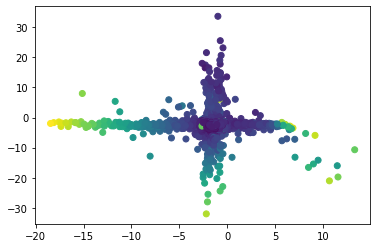

In [406]:
plt.scatter(simple_data[:, 0], simple_data[:, 1], c=simple_data[:, -1])
# plt.ylim(-5, 2)
# plt.xlim(-5, 2)

In [408]:
# num= 50
# x = np.linspace(-12, 2, num=num)
# y = np.linspace(-12, 2, num=num)
# X,Y = np.meshgrid(x, y) # grid of point
# Z = gp.predict(np.stack((X.ravel(), Y.ravel()), axis=1)).reshape(*[num]*2) # evaluation of the function on the grid

# im = plt.imshow(np.log10(Z), cmap='viridis', extent=[-12, 2, -12, 2], origin='lower')
# plt.colorbar()

In [29]:
from bayes_opt import BayesianOptimization

In [30]:
optimizer = BayesianOptimization(
    f=bb,
    pbounds=pbounds,
    random_state=1,
)

In [31]:
optimizer.maximize(init_points=4**len(cur_std), n_iter=300+4**len(cur_std), alpha=1e-2, normalize_y=True)

|   iter    |  target   |    s0     |    s1     |    s2     |    s3     |
-------------------------------------------------------------------------
|  1        | -19.02    | -2.489    |  6.61     | -15.0     | -5.93     |
|  2        | -30.0     | -10.6     | -12.23    | -9.412    | -4.633    |
|  3        | -12.14    | -3.097    |  1.165    | -2.424    |  5.557    |
|  4        | -22.75    | -8.866    |  11.34    | -14.18    |  5.114    |
|  5        | -18.32    | -2.481    |  1.761    | -10.79    | -9.057    |
|  6        | -30.0     |  9.022    |  14.05    | -5.597    |  5.77     |
|  7        | -30.0     |  11.29    |  11.84    | -12.45    | -13.83    |
|  8        | -23.0     | -9.905    |  11.34    | -12.05    | -2.367    |
|  9        | -30.0     |  13.74    |  0.995    |  5.756    | -5.535    |
|  10       | -30.0     |  5.595    |  10.04    | -14.45    |  7.504    |
|  11       | -30.0     |  14.67    |  7.445    | -6.587    |  8.678    |
|  12       | -25.32    | -11.9     | 

KeyboardInterrupt: 

In [33]:
optimizer.max

{'target': -7.024937629699707,
 'params': {'s0': -1.5170019728292918,
  's1': -3.2433987013595225,
  's2': -0.27262712630267544,
  's3': 10.6150648487571}}

In [34]:
for l1 in init_params:
    if (len(l1)) == 0: continue
    for l2 in l1:
        print(l2.shape)

(4, 30)
(30,)
(30, 30)
(30,)
(30, 30)
(30,)
(30, 1)
(1,)


In [37]:
simple_data = np.array(
[[t['params']['s%d'%(i,)] for i in range(len(cur_std))] + [t['target']]
for t in optimizer.res])

In [42]:
np.save('hidden={}_layers={}_results.npy'.format(args.hidden_dim, args.layers), simple_data)

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [44]:
gp = GaussianProcessRegressor(alpha=1e-2, n_restarts_optimizer=20, normalize_y=True)

In [568]:
# simple_data[:, -1].min()

7.440377235412598

In [45]:
gp.fit(simple_data[:, :-1], simple_data[:, -1])

GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=20, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [47]:
simple_data[:, :-1][gp.predict(simple_data[:, :-1]).argmin()]

array([  9.00996737,  -2.20082525,   3.21046382, -10.63603169])